In [ ]:
import pandas as pd

summary_features = pd.read_csv('/content/participant_summary_new.csv')
#summary_features = pd.read_csv('/content/drive/My Drive/full_participant_summary.csv')

print(summary_features.shape)

(275, 1014)


In [ ]:
new_names = []
for i in range(1, 50):  # f1 to f49
    for stat in ['mean', 'std', 'min', 'max']:
        new_names.append(f'OpenFace_f{i}_{stat}')

# Apply renaming to your dataframe
column_indices_to_rename = range(802, 998)  # Inclusive of 802 to 997
summary_features.columns.values[list(column_indices_to_rename)] = new_names

In [ ]:
summary_features = summary_features.loc[:, (summary_features != 0).any(axis=0)]

In [ ]:
summary_features.shape

(275, 806)

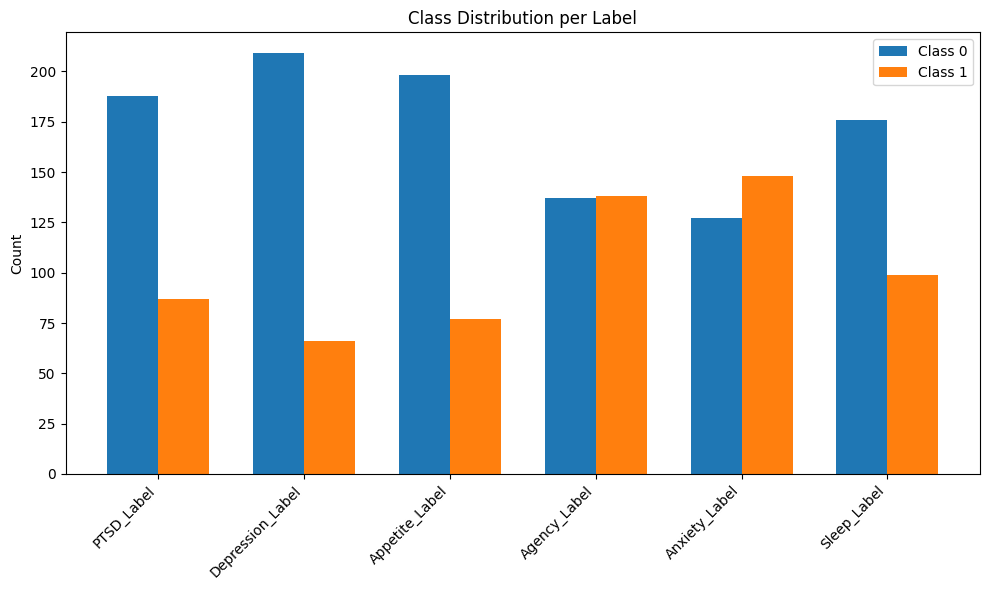

In [ ]:
import matplotlib.pyplot as plt

# Load your label CSV
df = pd.read_csv('/content/GroundTruth Table.csv')

# Define labels
labels = ['PTSD_Label',	'Depression_Label',	'Appetite_Label',	'Agency_Label',	'Anxiety_Label',	'Sleep_Label']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(labels))
zeros = [df[label].value_counts().get(0, 0) for label in labels]
ones = [df[label].value_counts().get(1, 0) for label in labels]

bar_width = 0.35
ax.bar([i - bar_width/2 for i in x], zeros, width=bar_width, label='Class 0')
ax.bar([i + bar_width/2 for i in x], ones, width=bar_width, label='Class 1')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Class Distribution per Label')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Separate features (summary_features) and the identified labels
X = summary_features
# y = df[labels[0]] #i =0, 1, 2, 3, 4, 5 for different targets

# # Initialize StratifiedKFold with 5 splits
# n_splits = 5  # Set to 5 for 5 iterations/folds
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
X = summary_features.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
X.shape

(275, 806)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

    return mi_scores

# mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores  # show a few features with their MI scores

In [ ]:
openface_feature_names = [
    'pose_Tx', 'pose_Ty', 'pose_Tz',
    'pose_Rx', 'pose_Ry', 'pose_Rz',
    'gaze_0_x', 'gaze_0_y', 'gaze_0_z',
    'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
    'gaze_angle_x', 'gaze_angle_y',
    'Inner_brow_raiser_r', 'Outer brow raiser_r', 'Brow lowerer_r', 'Upper lid raiser_r', 'Cheek raiser (smile-related)_r',
    'Lid tightener (squint)_r', 'Nose wrinkler_r', 'Upper lip raiser_r', 'Lip corner puller (smile)_r', 'Dimpler (cheek dimples)_r',
    'Lip corner depressor_r', 'Chin raiser_r', 'Lip stretcher_r', 'Lip tightener_r', 'Lips part_r', 'Jaw drop_r', 'Blink (eye closed)_r',
    'Inner brow raiser_c', 'Outer brow raiser_c', 'Brow lowerer_c', 'Upper lid raiser_c', 'Cheek raiser (smile-related)_c',
    'Lid tightener (squint)_c', 'Nose wrinkler_c', 'Upper lip raiser_c', 'Lip corner puller (smile)_c', 'Dimpler (cheek dimples)_c',
    'Lip corner depressor_c', 'Chin raiser_c', 'Lip stretcher_c', 'Lip tightener_c', 'Lips part_c', 'Jaw drop_c',
    'Lip suck_c', 'Blink (eye closed)_c'
]

openface_map = {f'OpenFace_f{i+1}': feature for i, feature in enumerate(openface_feature_names)}

In [ ]:
from collections import defaultdict

# Create inverse mapping: feature -> OpenFace_f name
inv_openface_map = {v: k for k, v in openface_map.items()}

# Now use the earlier categorization to build the new dict
feature_categories_renamed = defaultdict(list)

# Use the original categories to build the renamed version
original_categories = {
    "Eyes": [
        "gaze_0_x", "gaze_0_y", "gaze_0_z",
        "gaze_1_x", "gaze_1_y", "gaze_1_z",
        "gaze_angle_x", "gaze_angle_y",
        "Upper lid raiser_r", "Upper lid raiser_c",
        "Lid tightener (squint)_r", "Lid tightener (squint)_c",
        "Blink (eye closed)_r", "Blink (eye closed)_c"
    ],
    "Brows": [
        "Inner brow raiser_r", "Inner brow raiser_c",
        "Outer brow raiser_r", "Outer brow raiser_c",
        "Brow lowerer_r", "Brow lowerer_c"
    ],
    "Lips/Mouth/Jaw": [
        "Upper lip raiser_r", "Upper lip raiser_c",
        "Lip corner puller (smile)_r", "Lip corner puller (smile)_c",
        "Dimpler (cheek dimples)_r", "Dimpler (cheek dimples)_c",
        "Lip corner depressor_r", "Lip corner depressor_c",
        "Chin raiser_r", "Chin raiser_c",
        "Lip stretcher_r", "Lip stretcher_c",
        "Lip tightener_r", "Lip tightener_c",
        "Lips part_r", "Lips part_c",
        "Jaw drop_r", "Jaw drop_c",
        "Lip suck_c"
    ],
    "Nose": [
        "Nose wrinkler_r", "Nose wrinkler_c"
    ],
    "HeadPose": [
        "pose_Tx", "pose_Ty", "pose_Tz",
        "pose_Rx", "pose_Ry", "pose_Rz"
    ]
}


# Populate renamed category dictionary
for category, features in original_categories.items():
    for feature in features:
        if feature in inv_openface_map:
            feature_categories_renamed[category].append(inv_openface_map[feature])

# Convert back to regular dict
feature_categories_renamed = dict(feature_categories_renamed)


In [ ]:
from collections import defaultdict

# List of stats to append
stats = ['mean', 'std', 'min', 'max']

# Expanded dictionary
feature_categories_expanded = defaultdict(list)

# Build the expanded version
for category, features in feature_categories_renamed.items():
    for feature in features:
        for stat in stats:
            feature_categories_expanded[category].append(f"{feature}_{stat}")

# Convert to regular dict
feature_categories_expanded = dict(feature_categories_expanded)

In [ ]:
import shap
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# Load your datasets
df = pd.read_csv('/content/GroundTruth Table.csv')
# summary_features = pd.read_csv('/content/participant_summary_new.csv')

labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    return pd.Series(mi_scores, index=X.columns)

shap_feature_ranking = {}
top_shap_feature_by_category = {}
shap_feature_sums = {}

for label in labels:
    print(f"\n=== SHAP Analysis for: {label} ===")

    X = summary_features.copy()
    y = df[label]

    discrete_features = [False] * X.shape[1]
    mi_scores = make_mi_scores(X, y, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X[filtered_scores.index]

    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    top_features = final_scores.sort_values(ascending=False).head(int(len(final_scores) * 0.2))
    X = final_X[top_features.index]

    # Standardize + Oversample
    X_scaled = StandardScaler().fit_transform(X)
    X_resampled, y_resampled = SMOTE().fit_resample(X_scaled, y)

    model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
    model.fit(X_resampled, y_resampled)

    # SHAP Tree Explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    shap_df = pd.DataFrame(np.abs(shap_values).mean(axis=0), index=X.columns, columns=['mean_abs_shap'])

    # Aggregate SHAP by category
    shap_sums = {
        'shapley_eyes': 0.0,
        'shapley_brows': 0.0,
        'shapley_lips_mouth_jaw': 0.0,
        'shapley_nose': 0.0,
        'shapley_headpose': 0.0,
        'shapley_mfcc': 0.0,
        'shapley_egemaps': 0.0
    }

    for feature, shap_value in shap_df['mean_abs_shap'].items():
        # Check OpenFace categories
        for category, feature_list in feature_categories_expanded.items():
            if feature in feature_list:
                key = f"shapley_{category.lower().replace('/', '_').replace(' ', '_')}"
                if key in shap_sums:
                    shap_sums[key] += shap_value
                break
        else:
            # If not in OpenFace, check if it's MFCC or eGeMAPS
            if 'MFCC' in feature:
                shap_sums['shapley_mfcc'] += shap_value
            elif 'eGeMAPS' in feature:
                shap_sums['shapley_egemaps'] += shap_value

    shap_feature_sums[label] = shap_sums

    top_features_dict = {}

    for category, feature_list in feature_categories_expanded.items():
        key = f"shapley_{category.lower().replace('/', '_').replace(' ', '_')}"
        matching_features = [f for f in shap_df.index if f in feature_list]
        if matching_features:
            top_feat = shap_df.loc[matching_features].sort_values(by='mean_abs_shap', ascending=False).iloc[0]
            top_features_dict[key] = (top_feat.name, float(top_feat['mean_abs_shap']))

    # MFCC
    mfcc_feats = [f for f in shap_df.index if 'MFCC' in f]
    if mfcc_feats:
        top_feat = shap_df.loc[mfcc_feats].sort_values(by='mean_abs_shap', ascending=False).iloc[0]
        top_features_dict['shapley_mfcc'] = (top_feat.name, float(top_feat['mean_abs_shap']))

    # eGeMAPS
    egemaps_feats = [f for f in shap_df.index if 'eGeMAPS' in f]
    if egemaps_feats:
        top_feat = shap_df.loc[egemaps_feats].sort_values(by='mean_abs_shap', ascending=False).iloc[0]
        top_features_dict['shapley_egemaps'] = (top_feat.name, float(top_feat['mean_abs_shap']))

    top_shap_feature_by_category[label] = top_features_dict

# Print final results
import json
print(json.dumps(top_shap_feature_by_category, indent=2))


=== SHAP Analysis for: PTSD_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:04:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Depression_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:04:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Appetite_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:04:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Agency_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:04:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Anxiety_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:04:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Sleep_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:04:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{
  "PTSD_Label": {
    "shapley_eyes": [
      "OpenFace_f20_min",
      0.43590250611305237
    ],
    "shapley_lips_mouth_jaw": [
      "OpenFace_f27_max",
      0.18731559813022614
    ],
    "shapley_nose": [
      "OpenFace_f21_max",
      0.024211008101701736
    ],
    "shapley_headpose": [
      "OpenFace_f3_std",
      0.3389406204223633
    ],
    "shapley_mfcc": [
      "MFCC_f34_max",
      0.7574558258056641
    ],
    "shapley_egemaps": [
      "eGeMAPS_f67_max",
      0.6377825736999512
    ]
  },
  "Depression_Label": {
    "shapley_eyes": [
      "OpenFace_f9_std",
      0.3933853805065155
    ],
    "shapley_lips_mouth_jaw": [
      "OpenFace_f30_min",
      0.7685856819152832
    ],
    "shapley_nose": [
      "OpenFace_f21_max",
      0.10038785636425018
    ],
    "shapley_headpose": [
      "OpenFace_f1_max",
      0.27970483899116516
    ],
    "shapley_mfcc": [
      "MFCC_f76_std",
      0.3814409673213959
    ],
    "shapley_egemaps": [
      "eGeMAPS_f82_max

In [ ]:
import shap
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# Load your datasets
df = pd.read_csv('/content/GroundTruth Table.csv')
# summary_features = pd.read_csv('/content/participant_summary_new.csv')

labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    return pd.Series(mi_scores, index=X.columns)

shap_feature_ranking = {}
top_shap_feature_by_category = {}
shap_feature_sums = {}

for label in labels:
    print(f"\n=== SHAP Analysis for: {label} ===")

    X = summary_features.copy()
    y = df[label]

    X = X.loc[:, (X != 0).any(axis=0)]


    discrete_features = [False] * X.shape[1]
    mi_scores = make_mi_scores(X, y, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X[filtered_scores.index]
    filtered_X = filtered_X.loc[:, filtered_X.nunique() > 1]

    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    top_features = final_scores.loc[final_scores.index.intersection(final_X.columns)]
    top_features = top_features.sort_values(ascending=False).head(max(1, int(len(top_features) * 0.2)))
    X = final_X[top_features.index]
    print(X)
    # Standardize + Oversample
    X_scaled = StandardScaler().fit_transform(X)
    X_resampled, y_resampled = SMOTE().fit_resample(X_scaled, y)

    model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
    model.fit(X_resampled, y_resampled)

    # SHAP Tree Explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    shap_df = pd.DataFrame(np.abs(shap_values).mean(axis=0), index=X.columns, columns=['mean_abs_shap'])

    # Aggregate SHAP by category
    shap_sums = {
        'shapley_eyes': 0.0,
        'shapley_brows': 0.0,
        'shapley_lips_mouth_jaw': 0.0,
        'shapley_nose': 0.0,
        'shapley_headpose': 0.0,
        'shapley_mfcc': 0.0,
        'shapley_egemaps': 0.0
    }

    for feature, shap_value in shap_df['mean_abs_shap'].items():
        # Check OpenFace categories
        for category, feature_list in feature_categories_expanded.items():
            if feature in feature_list:
                key = f"shapley_{category.lower().replace('/', '_').replace(' ', '_')}"
                if key in shap_sums:
                    shap_sums[key] += shap_value
                break
        else:
            # If not in OpenFace, check if it's MFCC or eGeMAPS
            if 'MFCC' in feature:
                shap_sums['shapley_mfcc'] += shap_value
            elif 'eGeMAPS' in feature:
                shap_sums['shapley_egemaps'] += shap_value

    shap_feature_sums[label] = shap_sums

    top_features_dict = {}

    for category, feature_list in feature_categories_expanded.items():
      key = f"shapley_{category.lower().replace('/', '_').replace(' ', '_')}"
      matching_features = [f for f in shap_df.index if f in feature_list]

      if matching_features:
          sorted_feats = shap_df.loc[matching_features].sort_values(by='mean_abs_shap', ascending=False)
          top_n = max(1, int(len(sorted_feats)))  # Top 10%
          top_feats = sorted_feats.head(top_n)
          top_features_dict[key] = [
              (feat, float(shap_val)) for feat, shap_val in top_feats.itertuples()
          ]


    # MFCC
    mfcc_feats = [f for f in shap_df.index if 'MFCC' in f]
    if mfcc_feats:
        sorted_feats = shap_df.loc[mfcc_feats].sort_values(by='mean_abs_shap', ascending=False)
        top_n = max(1, int(len(sorted_feats) * 0.25))
        top_features_dict['shapley_mfcc'] = [
            (feat, float(shap_val)) for feat, shap_val in sorted_feats.head(top_n).itertuples()
        ]


    # eGeMAPS
    egemaps_feats = [f for f in shap_df.index if 'eGeMAPS' in f]
    if egemaps_feats:
        sorted_feats = shap_df.loc[egemaps_feats].sort_values(by='mean_abs_shap', ascending=False)
        top_n = max(1, int(len(sorted_feats) * 0.25))
        top_features_dict['shapley_egemaps'] = [
            (feat, float(shap_val)) for feat, shap_val in sorted_feats.head(top_n).itertuples()
        ]

    top_shap_feature_by_category[label] = top_features_dict

# Print final results
import json
print(json.dumps(top_shap_feature_by_category, indent=2))


=== SHAP Analysis for: PTSD_Label ===
     MFCC_f5_std  MFCC_f51_mean  OpenFace_f10_max  OpenFace_f21_max  \
0       0.059548       0.085311          0.304599          0.929809   
1       0.072915       0.349344          0.356575          1.086831   
2       0.040791       0.127582          0.276519          1.233998   
3       0.267954       0.328659          0.119316          1.889696   
4       0.189701       0.119172          0.236746          0.726185   
..           ...            ...               ...               ...   
270     0.101494       0.257564          0.296642          2.029718   
271     0.115708       0.280169          0.401679          1.758909   
272     0.091709       0.238585          0.385069          1.097386   
273     0.245308       0.227820          0.421270          1.384064   
274     0.149266       0.187222          0.377856          1.730994   

     eGeMAPS_f16_mean  OpenFace_f11_min  eGeMAPS_f38_std  MFCC_f38_mean  \
0            1.097817          0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Depression_Label ===
     OpenFace_f19_mean  MFCC_f22_max  MFCC_f26_max  OpenFace_f9_std  \
0             0.478257      1.740363      0.778151        -0.999705   
1             0.256384      1.612784      1.113943        -0.997822   
2             0.373529      1.623249      0.602060        -0.999927   
3             0.500688      1.643453      1.431364        -1.000000   
4             0.545234      1.623249      1.380211        -0.999953   
..                 ...           ...           ...              ...   
270           0.555362      1.698970      1.255273        -0.996567   
271           0.488397      1.770852      0.903090        -0.999926   
272           0.312621      1.770852      0.954242        -0.999967   
273           0.429412      1.707570      1.462398        -0.999605   
274           0.537086      1.724276      0.903090        -0.999983   

     MFCC_f16_max  MFCC_f100_std  eGeMAPS_f54_std  eGeMAPS_f52_std  \
0        0.000000       0.359292

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Appetite_Label ===
     eGeMAPS_f6_mean  MFCC_f46_max  OpenFace_f1_std  eGeMAPS_f16_mean  \
0           0.046243      0.477121           -122.2          1.097817   
1           0.049159      0.954242             -4.1          1.483259   
2           0.008674      0.301030            -70.5          1.508869   
3           0.151256      0.903090            -65.1          1.230685   
4           0.103073      0.903090             19.0          1.346308   
..               ...           ...              ...               ...   
270         0.020053      0.845098           -149.8          1.653223   
271         0.008090      0.778151            -93.1          1.380749   
272         0.000000      0.477121            -86.7          1.619005   
273         0.010416      0.845098            -96.0          1.232321   
274         0.142484      0.778151            -75.6          1.374387   

     eGeMAPS_f53_mean  OpenFace_f48_mean  eGeMAPS_f51_std  MFCC_f76_max  \
0    

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Agency_Label ===
     eGeMAPS_f49_std  MFCC_f64_max  OpenFace_f9_mean  OpenFace_f11_max  \
0           0.000000      0.602060          0.029585         -0.941763   
1           0.000000      1.000000          0.033944         -0.928320   
2           0.000000      0.477121          0.022883         -0.947274   
3           0.000000      0.845098          0.020903         -0.980304   
4           0.000000      0.477121          0.019860         -0.937227   
..               ...           ...               ...               ...   
270         0.056400      0.477121          0.033553         -0.944027   
271         0.000000      0.778151          0.039515         -0.876001   
272         0.063566      0.477121          0.023977         -0.857072   
273         0.066554      0.698970          0.037756         -0.857577   
274         0.238920      0.602060          0.042738         -0.896367   

     OpenFace_f23_mean  MFCC_f3_std  MFCC_f43_max  OpenFace_f11_mean  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Anxiety_Label ===
     OpenFace_f9_mean  eGeMAPS_f9_mean  OpenFace_f8_std  eGeMAPS_f98_min  \
0            0.029585         0.000000        -0.414840         0.000000   
1            0.033944         0.001461        -0.127692         0.000000   
2            0.022883         0.007635        -0.156501         0.000000   
3            0.020903         0.003796        -0.358011         0.000000   
4            0.019860         0.005749        -0.429877         0.477121   
..                ...              ...              ...              ...   
270          0.033553         0.066917        -0.268151         0.000000   
271          0.039515         0.060988        -0.346415         0.000000   
272          0.023977         0.026518        -0.221140         0.301030   
273          0.037756         0.063002        -0.085166         0.000000   
274          0.042738         0.103028        -0.441516         0.000000   

     MFCC_f50_mean  OpenFace_f6_min  eGeMAPS_

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Sleep_Label ===
     MFCC_f59_max  eGeMAPS_f73_std  eGeMAPS_f16_mean  eGeMAPS_f20_max  \
0         0.00000         0.068249          1.097817         0.000000   
1         0.00000         0.141435          1.483259         0.000000   
2         0.00000         0.107976          1.508869         0.000000   
3         0.30103         0.079940          1.230685         0.000000   
4         0.00000         0.037029          1.346308         0.301030   
..            ...              ...               ...              ...   
270       0.00000         0.060019          1.653223         0.301030   
271       0.00000         0.216420          1.380749         0.477121   
272       0.00000         0.454305          1.619005         0.477121   
273       0.00000         0.283133          1.232321         0.301030   
274       0.30103         0.114252          1.374387         0.000000   

     OpenFace_f11_min  eGeMAPS_f69_std  eGeMAPS_f53_max  OpenFace_f8_std  \
0      

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{
  "PTSD_Label": {
    "shapley_eyes": [
      [
        "OpenFace_f10_max",
        0.3647844195365906
      ],
      [
        "OpenFace_f35_max",
        0.30696749687194824
      ],
      [
        "OpenFace_f14_std",
        0.18325744569301605
      ],
      [
        "OpenFace_f11_min",
        0.10343588888645172
      ],
      [
        "OpenFace_f18_min",
        0.07995204627513885
      ]
    ],
    "shapley_lips_mouth_jaw": [
      [
        "OpenFace_f30_min",
        0.2387022227048874
      ],
      [
        "OpenFace_f28_min",
        0.13915322721004486
      ],
      [
        "OpenFace_f27_max",
        0.07983566075563431
      ],
      [
        "OpenFace_f48_mean",
        0.04020138829946518
      ],
      [
        "OpenFace_f48_min",
        0.0
      ]
    ],
    "shapley_nose": [
      [
        "OpenFace_f21_max",
        0.03959698975086212
      ]
    ],
    "shapley_headpose": [
      [
        "OpenFace_f4_mean",
        0.38203251361846924
      ],
 

In [ ]:
import pandas as pd

# Flatten the nested dictionary into a list of rows
rows = []
for label, category_dict in top_shap_feature_by_category.items():
    for category, (feature, shap_value) in category_dict.items():
        rows.append({
            'Label': label,
            'Category': category.replace("shapley_", "").replace("_", " ").title(),
            'Top Feature': feature,
            'SHAP Value': shap_value
        })

# Create DataFrame
top_feature_df = pd.DataFrame(rows)

# Optional: sort for better readability
top_feature_df = top_feature_df.sort_values(by=['Label', 'Category'])

# # Display the table
# print(top_feature_df.to_string(index=False))


ValueError: too many values to unpack (expected 2)

In [ ]:
import re

def replace_openface_feature_name(feature):
    # Match 'OpenFace_fX' from full feature name like 'OpenFace_f34_max'
    match = re.match(r'(OpenFace_f\d+)', feature)
    if match:
        base_name = match.group(1)
        mapped_name = openface_map.get(base_name)
        if mapped_name:
            # Replace only the base name with the mapped one, keep rest (e.g., '_mean')
            return feature.replace(base_name, mapped_name)
    return feature  # Leave unchanged if not OpenFace

# Apply the renaming to the 'Top Feature' column
top_feature__renamed_df = top_feature_df.copy()
top_feature__renamed_df['Top Feature'] = top_feature__renamed_df['Top Feature'].apply(replace_openface_feature_name)

# Now display the updated DataFrame
print(top_feature__renamed_df.to_string(index=False))


NameError: name 'top_feature_df' is not defined

In [ ]:
import shap
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# Load your datasets
df = pd.read_csv('/content/GroundTruth Table.csv')
# summary_features = pd.read_csv('/content/participant_summary_new.csv')

labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    return pd.Series(mi_scores, index=X.columns)

shap_feature_ranking = {}

shap_feature_sums = {}

for label in labels:
    print(f"\n=== SHAP Analysis for: {label} ===")

    X = summary_features.copy()
    y = df[label]

    discrete_features = [False] * X.shape[1]
    mi_scores = make_mi_scores(X, y, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X[filtered_scores.index]

    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    top_features = final_scores.loc[final_scores.index.intersection(final_X.columns)]
    top_features = top_features.sort_values(ascending=False).head(max(1, int(len(top_features) * 0.2)))
    X = final_X[top_features.index]

    # Standardize + Oversample
    X_scaled = StandardScaler().fit_transform(X)
    X_resampled, y_resampled = SMOTE().fit_resample(X_scaled, y)

    model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
    model.fit(X_resampled, y_resampled)

    # SHAP Tree Explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    shap_df = pd.DataFrame(np.abs(shap_values).mean(axis=0), index=X.columns, columns=['mean_abs_shap'])

    # Aggregate SHAP by category
    shap_sums = {
        'shapley_eyes': 0.0,
        'shapley_brows': 0.0,
        'shapley_lips_mouth_jaw': 0.0,
        'shapley_nose': 0.0,
        'shapley_headpose': 0.0,
        'shapley_mfcc': 0.0,
        'shapley_egemaps': 0.0
    }

    for feature, shap_value in shap_df['mean_abs_shap'].items():
        # Check OpenFace categories
        for category, feature_list in feature_categories_expanded.items():
            if feature in feature_list:
                key = f"shapley_{category.lower().replace('/', '_').replace(' ', '_')}"
                if key in shap_sums:
                    shap_sums[key] += shap_value
                break
        else:
            # If not in OpenFace, check if it's MFCC or eGeMAPS
            if 'MFCC' in feature:
                shap_sums['shapley_mfcc'] += shap_value
            elif 'eGeMAPS' in feature:
                shap_sums['shapley_egemaps'] += shap_value

    shap_feature_sums[label] = shap_sums

# Print final results
import json
print(json.dumps(shap_feature_sums, indent=2))


=== SHAP Analysis for: PTSD_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:58:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Depression_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:58:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Appetite_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:58:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Agency_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:58:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Anxiety_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:59:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SHAP Analysis for: Sleep_Label ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{
  "PTSD_Label": {
    "shapley_eyes": 0.29000599682331085,
    "shapley_brows": 0.0,
    "shapley_lips_mouth_jaw": 0.49135320633649826,
    "shapley_nose": 0.02289840392768383,
    "shapley_headpose": 1.2404912933707237,
    "shapley_mfcc": 2.5173982796259224,
    "shapley_egemaps": 2.9786504674702883
  },
  "Depression_Label": {
    "shapley_eyes": 0.49741031229496,
    "shapley_brows": 0.0,
    "shapley_lips_mouth_jaw": 0.4921412318944931,
    "shapley_nose": 0.31383639574050903,
    "shapley_headpose": 0.2949088215827942,
    "shapley_mfcc": 3.642621209844947,
    "shapley_egemaps": 3.9826137609779835
  },
  "Appetite_Label": {
    "shapley_eyes": 0.4222251661121845,
    "shapley_brows": 0.0,
    "shapley_lips_mouth_jaw": 0.6554895117878914,
    "shapley_nose": 0.0,
    "shapley_headpose": 0.512582004070282,
    "shapley_mfcc": 3.144507782533765,
    "shapley_egemaps": 4.16498919762671
  },
  "Agency_Label": {
    "shapley_eyes": 1.227988850325346,
    "shapley_brows": 0.131336688

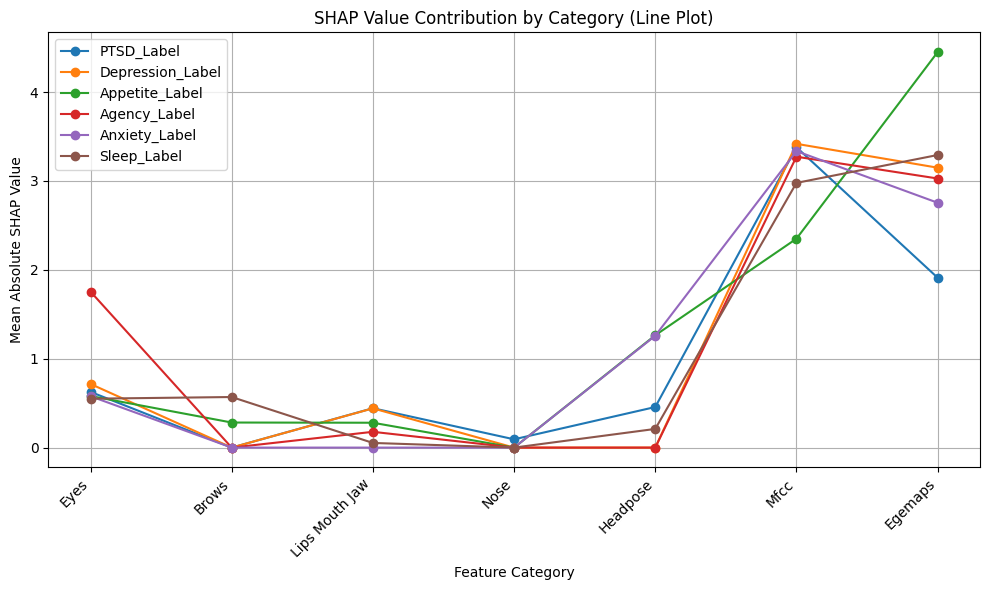

In [ ]:
import matplotlib.pyplot as plt

# X-axis labels
categories = list(next(iter(shap_feature_sums.values())).keys())

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each label's SHAP values as a line
for label, values in shap_feature_sums.items():
    shap_vals = list(values.values())
    plt.plot(categories, shap_vals, marker='o', label=label)

# Format x-axis labels
plt.xticks(ticks=range(len(categories)),
           labels=[c.replace("shapley_", "").replace("_", " ").title() for c in categories],
           rotation=45, ha='right')

# Styling
plt.xlabel("Feature Category")
plt.ylabel("Mean Absolute SHAP Value")
plt.title("SHAP Value Contribution by Category (Line Plot)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import shap
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# Load your datasets
df = pd.read_csv('/content/GroundTruth Table.csv')
# summary_features = pd.read_csv('/content/participant_summary_new.csv')

labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    return pd.Series(mi_scores, index=X.columns)

shap_feature_ranking = {}

for label in labels:
    print(f"\n=== SHAP Analysis for: {label} ===")

    X_full = summary_features.copy()
    y_full = df[label]

    discrete_features = [False] * X_full.shape[1]
    mi_scores = make_mi_scores(X_full, y_full, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X_full[filtered_scores.index]

    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    top_features = final_scores.sort_values(ascending=False).head(int(len(final_scores) * 0.2))
    X = final_X[top_features.index]
    y = y_full

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    shap_values_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train = StandardScaler().fit_transform(X_train)
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

        model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
        model.fit(X_resampled, y_resampled)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X.iloc[test_index])
        shap_values_list.append(np.abs(shap_values))

    # Mean SHAP across all folds
    mean_shap = np.mean(np.concatenate(shap_values_list, axis=0), axis=0)
    shap_df = pd.DataFrame(mean_shap, index=X.columns, columns=['mean_abs_shap'])
    shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=False)

    # Compute how many features is 10% for each group
    audio_feats = [f for f in shap_df.index if 'MFCC' in f or 'eGeMAPS' in f]
    video_feats = [f for f in shap_df.index if 'OpenFace' in f]

    top_audio = audio_feats[:max(1, int(len(audio_feats) * 0.25))]
    top_video = video_feats[:max(1, int(len(video_feats) * 0.25))]


    shap_feature_ranking[label] = {
        'Top 5 Audio': top_audio,
        'Top 5 Video': top_video
    }

# Display final ranking
import json
print(json.dumps(shap_feature_ranking, indent=2))



=== SHAP Analysis for: PTSD_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:02] WARNING: /w


=== SHAP Analysis for: Depression_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:12] WARNING: /w


=== SHAP Analysis for: Appetite_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:28] WARNING: /w


=== SHAP Analysis for: Agency_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:41] WARNING: /w


=== SHAP Analysis for: Anxiety_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:49:59] WARNING: /w


=== SHAP Analysis for: Sleep_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:09] WARNING: /w

{
  "PTSD_Label": {
    "Top 5 Audio": [
      "eGeMAPS_f98_max",
      "eGeMAPS_f47_max",
      "eGeMAPS_f65_max",
      "MFCC_f47_max",
      "MFCC_f51_mean",
      "MFCC_f80_mean",
      "eGeMAPS_f66_mean",
      "eGeMAPS_f74_max",
      "MFCC_f25_std",
      "MFCC_f100_std",
      "MFCC_f11_mean"
    ],
    "Top 5 Video": [
      "OpenFace_f4_mean",
      "OpenFace_f10_max",
      "OpenFace_f19_max"
    ]
  },
  "Depression_Label": {
    "Top 5 Audio": [
      "MFCC_f18_max",
      "MFCC_f14_max",
      "MFCC_f35_max",
      "eGeMAPS_f11_mean",
      "MFCC_f45_std",
      "eGeMAPS_f86_max",
      "MFCC_f22_min",
      "eGeMAPS_f66_mean",
      "eGeMAPS_f92_mean",
      "eGeMAPS_f35_max",
      "MFCC_f65_max",
      "MFCC_f26_max"
    ],
    "Top 5 Video": [
      "OpenFace_f30_min",
      "OpenFace_f19_mean"
    ]
  },
  "Appetite_Label": {
    "Top 5 Audio": [
      "eGeMAPS_f66_mean",
      "eGeMAPS_f53_mean",
      "eGeMAPS_f73_max",
      "eGeMAPS_f86_max",
      "eGeMAPS_f7_st

In [ ]:
import shap
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif

# Load your datasets
df = pd.read_csv('/content/GroundTruth Table.csv')
# summary_features = pd.read_csv('/content/participant_summary_new.csv')

labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    return pd.Series(mi_scores, index=X.columns)

shap_feature_ranking = {}
feature_ranking = []

for label in labels:
    print(f"\n=== SHAP Analysis for: {label} ===")

    X = summary_features.copy()
    y = df[label]

    discrete_features = [False] * X.shape[1]
    mi_scores = make_mi_scores(X, y, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X[filtered_scores.index]

    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    top_features = final_scores.sort_values(ascending=False).head(int(len(final_scores) * 0.2))
    X = final_X[top_features.index]

    # Standardize + Oversample
    X_scaled = StandardScaler().fit_transform(X)
    X_resampled, y_resampled = SMOTE().fit_resample(X_scaled, y)

    model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
    model.fit(X_resampled, y_resampled)

    # SHAP Tree Explainer (CPU-compatible)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Mean absolute SHAP values per feature
    shap_df = pd.DataFrame(np.abs(shap_values).mean(axis=0), index=X.columns, columns=['mean_abs_shap'])
    shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=False)

    top_audio = [f for f in shap_df.index if 'MFCC' in f or 'eGeMAPS' in f][:5]
    top_video = [f for f in shap_df.index if 'OpenFace' in f][:5]
    top_transcript = [f for f in shap_df.index if 'MFCC' not in f and 'eGeMAPS' not in f and 'OpenFace' not in f and 'participant_id' not in f][:5]

    shap_feature_ranking[label] = {
        'Top 5 Audio': top_audio,
        'Top 5 Video': top_video,
        'Top 5 Transcript': top_transcript
    }

# Display final ranking
import json
print(json.dumps(shap_feature_ranking, indent=2))



=== SHAP Analysis for: PTSD_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== SHAP Analysis for: Depression_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== SHAP Analysis for: Appetite_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== SHAP Analysis for: Agency_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== SHAP Analysis for: Anxiety_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== SHAP Analysis for: Sleep_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{
  "PTSD_Label": {
    "Top 5 Audio": [
      "MFCC_f47_max",
      "MFCC_f25_max",
      "eGeMAPS_f98_max",
      "eGeMAPS_f67_max",
      "eGeMAPS_f88_mean"
    ],
    "Top 5 Video": [
      "OpenFace_f1_std",
      "OpenFace_f3_std",
      "OpenFace_f4_mean",
      "OpenFace_f14_std",
      "OpenFace_f27_max"
    ],
    "Top 5 Transcript": [
      "avg_pause_duration",
      "lexical_diversity"
    ]
  },
  "Depression_Label": {
    "Top 5 Audio": [
      "MFCC_f100_std",
      "MFCC_f34_max",
      "eGeMAPS_f60_max",
      "eGeMAPS_f38_mean",
      "MFCC_f26_max"
    ],
    "Top 5 Video": [
      "OpenFace_f9_std",
      "OpenFace_f30_max",
      "OpenFace_f19_mean",
      "OpenFace_f1_max",
      "OpenFace_f11_min"
    ],
    "Top 5 Transcript": [
      "avg_pause_duration"
    ]
  },
  "Appetite_Label": {
    "Top 5 Audio": [
      "eGeMAPS_f53_mean",
      "MFCC_f46_max",
      "eGeMAPS_f7_std",
      "eGeMAPS_f78_max",
      "MFCC_f34_max"
    ],
    "Top 5 Video": [
      "Op

In [ ]:
all_audio = {label: features['Top 5 Audio'] for label, features in shap_feature_ranking.items()}
all_video = {label: features['Top 5 Video'] for label, features in shap_feature_ranking.items()}


In [ ]:
print(all_audio)

{'PTSD_Label': ['eGeMAPS_f88_mean', 'eGeMAPS_f98_max', 'MFCC_f24_mean', 'MFCC_f43_max', 'MFCC_f25_std', 'eGeMAPS_f65_max', 'MFCC_f80_mean', 'MFCC_f70_max', 'MFCC_f100_std'], 'Depression_Label': ['eGeMAPS_f25_mean', 'eGeMAPS_f60_max', 'eGeMAPS_f38_mean', 'eGeMAPS_f28_max', 'eGeMAPS_f11_mean', 'eGeMAPS_f85_mean', 'MFCC_f45_std', 'MFCC_f76_std', 'eGeMAPS_f64_std', 'eGeMAPS_f66_std', 'MFCC_f5_std'], 'Appetite_Label': ['eGeMAPS_f53_mean', 'MFCC_f48_max', 'eGeMAPS_f7_std', 'eGeMAPS_f66_mean', 'MFCC_f46_max', 'MFCC_f17_max', 'MFCC_f90_max', 'eGeMAPS_f61_mean', 'eGeMAPS_f16_mean', 'MFCC_f78_max', 'MFCC_f35_mean'], 'Agency_Label': ['MFCC_f19_max', 'MFCC_f72_max', 'eGeMAPS_f65_mean', 'MFCC_f51_max', 'MFCC_f69_mean', 'MFCC_f93_std', 'eGeMAPS_f2_mean', 'MFCC_f3_std', 'eGeMAPS_f49_std', 'MFCC_f100_std', 'eGeMAPS_f72_max', 'MFCC_f90_std', 'MFCC_f2_std'], 'Anxiety_Label': ['eGeMAPS_f65_mean', 'eGeMAPS_f93_max', 'eGeMAPS_f63_max', 'MFCC_f82_mean', 'MFCC_f16_std', 'MFCC_f34_mean', 'eGeMAPS_f10_std', 'M

In [ ]:
top_feature_df.head()

,Label,Category,Top Feature,SHAP Value
20,Agency_Label,Brows,AU04_c_max,0.087464
24,Agency_Label,Egemaps,eGeMAPS_f65_mean,0.476815
19,Agency_Label,Eyes,gaze_0_z_mean,1.061696
22,Agency_Label,Headpose,pose_Tz_min,0.267964
21,Agency_Label,Lips Mouth Jaw,AU28_c_mean,0.158546


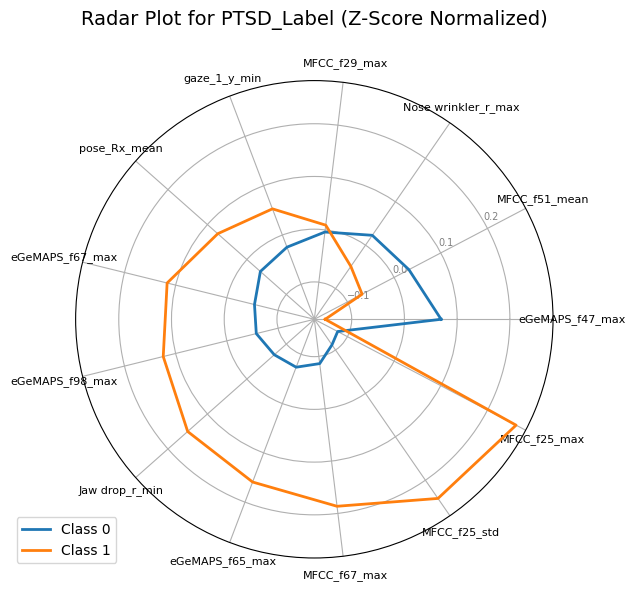

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
# top_audio_features =all_audio['PTSD_Label']
# top_video_features = all_video['PTSD_Label']
# # features = top_feature_df[top_feature_df['Label'] == 'PTSD_Label']['Top Feature']
# features = top_audio_features + top_video_features
features = []
for category, feature in top_shap_feature_by_category["PTSD_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'PTSD_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean for each class
group_0 = X[df[label_col] == 0][features].mean()
group_1 = X[df[label_col] == 1][features].mean()

# Radar plot setup
# Sort features based on whether class 0 or class 1 is higher
diff = group_1 - group_0
features_sorted = diff.sort_values().index.tolist()  # class 0 > 1 will be at top, class 1 > 0 at bottom

# Update all relevant data
values_0 = group_0[features_sorted].tolist() + [group_0[features_sorted].tolist()[0]]
values_1 = group_1[features_sorted].tolist() + [group_1[features_sorted].tolist()[0]]
angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0")
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1")

plt.title(f'Radar Plot for {label_col} (Z-Score Normalized)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()


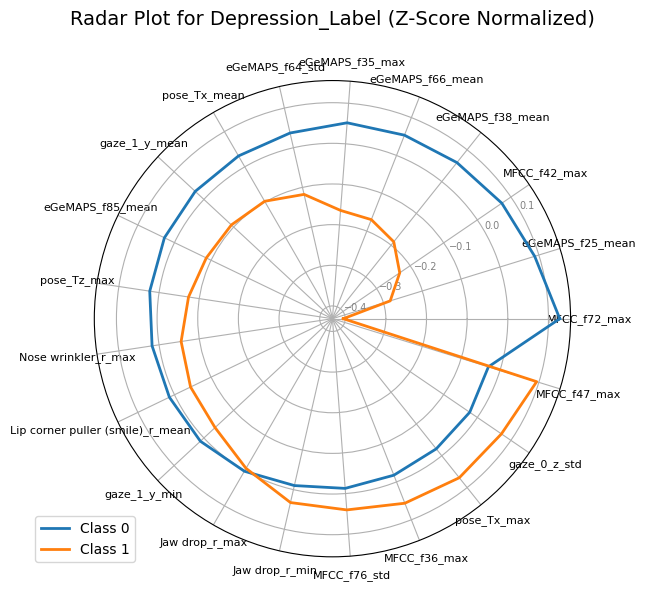

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Depression_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Depression_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean for each class
group_0 = X[df[label_col] == 0][features].mean()
group_1 = X[df[label_col] == 1][features].mean()

# Radar plot setup
# Sort features based on whether class 0 or class 1 is higher
diff = group_1 - group_0
features_sorted = diff.sort_values().index.tolist()  # class 0 > 1 will be at top, class 1 > 0 at bottom

# Update all relevant data
values_0 = group_0[features_sorted].tolist() + [group_0[features_sorted].tolist()[0]]
values_1 = group_1[features_sorted].tolist() + [group_1[features_sorted].tolist()[0]]
angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]


# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0")
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1")

plt.title(f'Radar Plot for {label_col} (Z-Score Normalized)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()


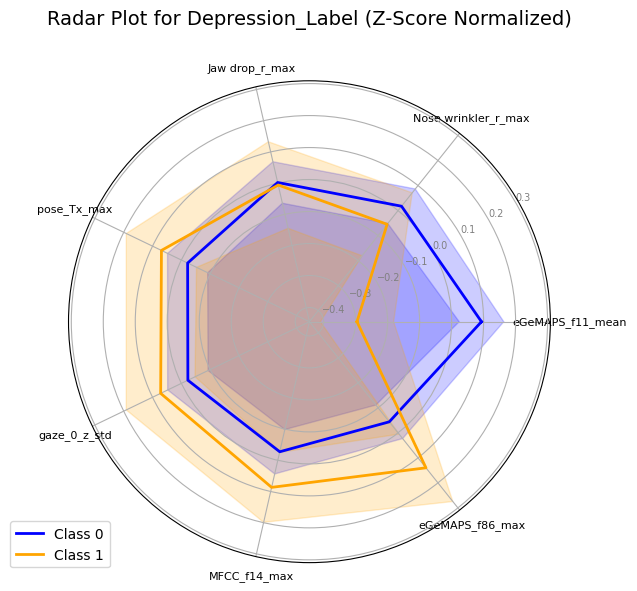

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Depression_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Depression_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and standard error for each class
group_0_data = X[df[label_col] == 0][features]
group_1_data = X[df[label_col] == 1][features]

group_0_mean = group_0_data.mean()
group_1_mean = group_1_data.mean()

group_0_sem = group_0_data.sem()
group_1_sem = group_1_data.sem()

# Sort features based on whether class 0 or class 1 is higher
diff = group_1_mean - group_0_mean
features_sorted = diff.sort_values().index.tolist()

# Get sorted means and SEMs, close the loop
mean_0 = group_0_mean[features_sorted].tolist()
mean_1 = group_1_mean[features_sorted].tolist()
sem_0 = group_0_sem[features_sorted].tolist()
sem_1 = group_1_sem[features_sorted].tolist()

mean_0 += [mean_0[0]]
mean_1 += [mean_1[0]]
sem_0 += [sem_0[0]]
sem_1 += [sem_1[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Plot lines
ax.plot(angles, mean_0, linewidth=2, linestyle='solid', label="Class 0", color='blue')
ax.plot(angles, mean_1, linewidth=2, linestyle='solid', label="Class 1", color='orange')

# Fill standard error
ax.fill(angles, np.array(mean_0) - np.array(sem_0), color='blue', alpha=0.2)
ax.fill(angles, np.array(mean_0) + np.array(sem_0), color='blue', alpha=0.2)

ax.fill(angles, np.array(mean_1) - np.array(sem_1), color='orange', alpha=0.2)
ax.fill(angles, np.array(mean_1) + np.array(sem_1), color='orange', alpha=0.2)

# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()


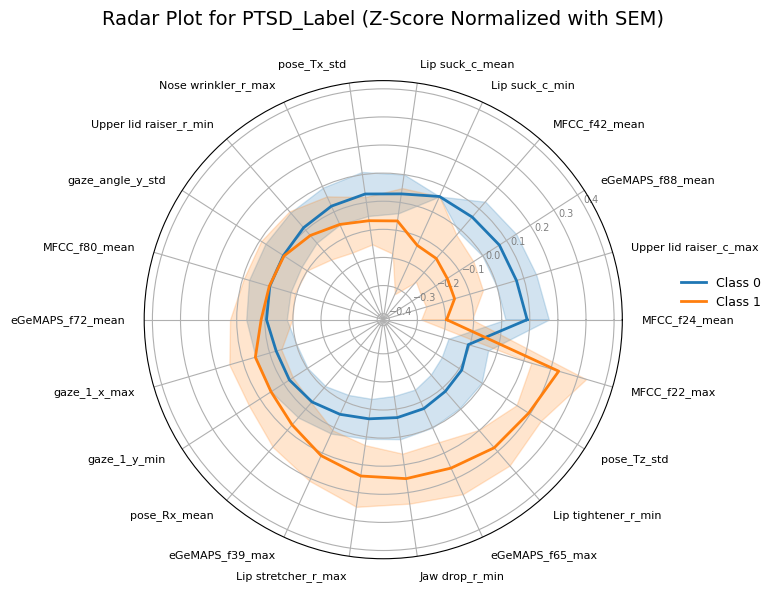

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["PTSD_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'PTSD_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and SEM for each class
group_0 = X[df[label_col] == 0][features]
group_1 = X[df[label_col] == 1][features]

mean_0 = group_0.mean()
sem_0 = group_0.sem()

mean_1 = group_1.mean()
sem_1 = group_1.sem()

# Sort features based on difference
diff = mean_1 - mean_0
features_sorted = diff.sort_values().index.tolist()

# Prepare data for plotting
values_0 = mean_0[features_sorted].tolist() + [mean_0[features_sorted].tolist()[0]]
values_1 = mean_1[features_sorted].tolist() + [mean_1[features_sorted].tolist()[0]]

sem_0_vals = sem_0[features_sorted].tolist() + [sem_0[features_sorted].tolist()[0]]
sem_1_vals = sem_1[features_sorted].tolist() + [sem_1[features_sorted].tolist()[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Set center empty
all_vals = np.concatenate([mean_0.values, mean_1.values, mean_0.values - sem_0.values, mean_1.values - sem_1.values])
ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.2)

# Plot mean lines
ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0", color='tab:blue')
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1", color='tab:orange')

# Add standard error shading
ax.fill_between(angles,
                np.array(values_0) - np.array(sem_0_vals),
                np.array(values_0) + np.array(sem_0_vals),
                color='tab:blue', alpha=0.2)

ax.fill_between(angles,
                np.array(values_1) - np.array(sem_1_vals),
                np.array(values_1) + np.array(sem_1_vals),
                color='tab:orange', alpha=0.2)

# Format labels
# Format labels (rotated outward to avoid overlap)
plt.xticks(angles[:-1], pretty_labels, color='black')
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if angle_deg >= 90 and angle_deg <= 270:
        label.set_rotation(angle_deg + 180)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('right')
    else:
        label.set_rotation(angle_deg)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('left')
    label.set_fontsize(8)

ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Title and legend
# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized with SEM)', size=14, y=1.1)

# Move legend outside on the right
plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), fontsize=9, frameon=False)

plt.tight_layout()
plt.show()



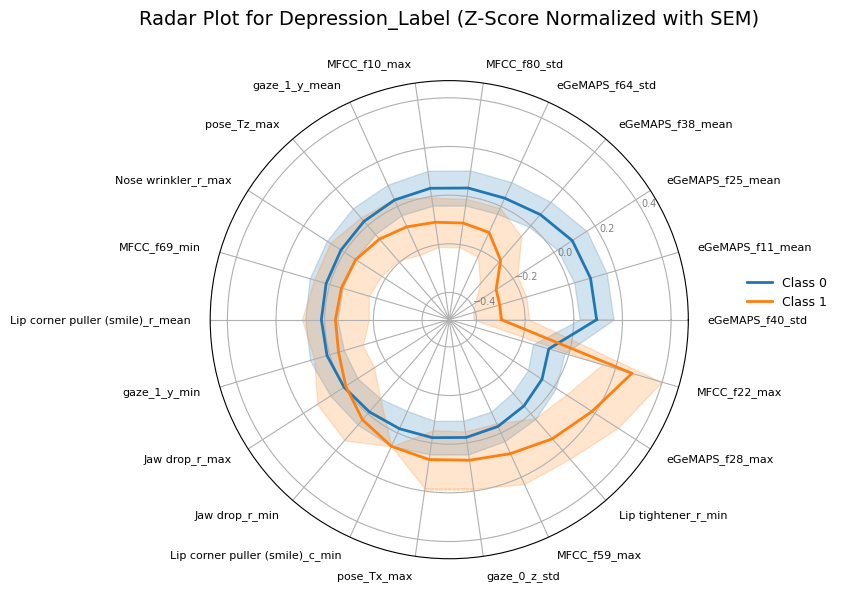

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Depression_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Depression_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and SEM for each class
group_0 = X[df[label_col] == 0][features]
group_1 = X[df[label_col] == 1][features]

mean_0 = group_0.mean()
sem_0 = group_0.sem()

mean_1 = group_1.mean()
sem_1 = group_1.sem()

# Sort features based on difference
diff = mean_1 - mean_0
features_sorted = diff.sort_values().index.tolist()

# Prepare data for plotting
values_0 = mean_0[features_sorted].tolist() + [mean_0[features_sorted].tolist()[0]]
values_1 = mean_1[features_sorted].tolist() + [mean_1[features_sorted].tolist()[0]]

sem_0_vals = sem_0[features_sorted].tolist() + [sem_0[features_sorted].tolist()[0]]
sem_1_vals = sem_1[features_sorted].tolist() + [sem_1[features_sorted].tolist()[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Set center empty
all_vals = np.concatenate([mean_0.values, mean_1.values, mean_0.values - sem_0.values, mean_1.values - sem_1.values])
ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.2)

# Plot mean lines
ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0", color='tab:blue')
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1", color='tab:orange')

# Add standard error shading
ax.fill_between(angles,
                np.array(values_0) - np.array(sem_0_vals),
                np.array(values_0) + np.array(sem_0_vals),
                color='tab:blue', alpha=0.2)

ax.fill_between(angles,
                np.array(values_1) - np.array(sem_1_vals),
                np.array(values_1) + np.array(sem_1_vals),
                color='tab:orange', alpha=0.2)

# Format labels
# Format labels (rotated outward to avoid overlap)
plt.xticks(angles[:-1], pretty_labels, color='black')
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if angle_deg >= 90 and angle_deg <= 270:
        label.set_rotation(angle_deg + 180)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('right')
    else:
        label.set_rotation(angle_deg)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('left')
    label.set_fontsize(8)

ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Title and legend
# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized with SEM)', size=14, y=1.1)

# Move legend outside on the right
plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), fontsize=9, frameon=False)

plt.tight_layout()
plt.show()



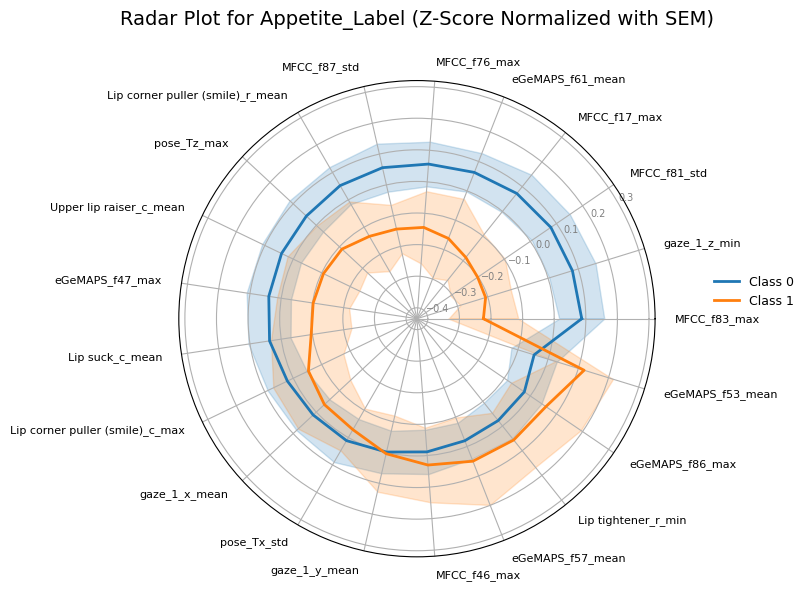

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Appetite_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Appetite_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and SEM for each class
group_0 = X[df[label_col] == 0][features]
group_1 = X[df[label_col] == 1][features]

mean_0 = group_0.mean()
sem_0 = group_0.sem()

mean_1 = group_1.mean()
sem_1 = group_1.sem()

# Sort features based on difference
diff = mean_1 - mean_0
features_sorted = diff.sort_values().index.tolist()

# Prepare data for plotting
values_0 = mean_0[features_sorted].tolist() + [mean_0[features_sorted].tolist()[0]]
values_1 = mean_1[features_sorted].tolist() + [mean_1[features_sorted].tolist()[0]]

sem_0_vals = sem_0[features_sorted].tolist() + [sem_0[features_sorted].tolist()[0]]
sem_1_vals = sem_1[features_sorted].tolist() + [sem_1[features_sorted].tolist()[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Set center empty
all_vals = np.concatenate([mean_0.values, mean_1.values, mean_0.values - sem_0.values, mean_1.values - sem_1.values])
ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.2)

# Plot mean lines
ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0", color='tab:blue')
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1", color='tab:orange')

# Add standard error shading
ax.fill_between(angles,
                np.array(values_0) - np.array(sem_0_vals),
                np.array(values_0) + np.array(sem_0_vals),
                color='tab:blue', alpha=0.2)

ax.fill_between(angles,
                np.array(values_1) - np.array(sem_1_vals),
                np.array(values_1) + np.array(sem_1_vals),
                color='tab:orange', alpha=0.2)

# Format labels
# Format labels (rotated outward to avoid overlap)
plt.xticks(angles[:-1], pretty_labels, color='black')
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if angle_deg >= 90 and angle_deg <= 270:
        label.set_rotation(angle_deg + 180)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('right')
    else:
        label.set_rotation(angle_deg)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('left')
    label.set_fontsize(8)

ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Title and legend
# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized with SEM)', size=14, y=1.1)

# Move legend outside on the right
plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), fontsize=9, frameon=False)

plt.tight_layout()
plt.show()



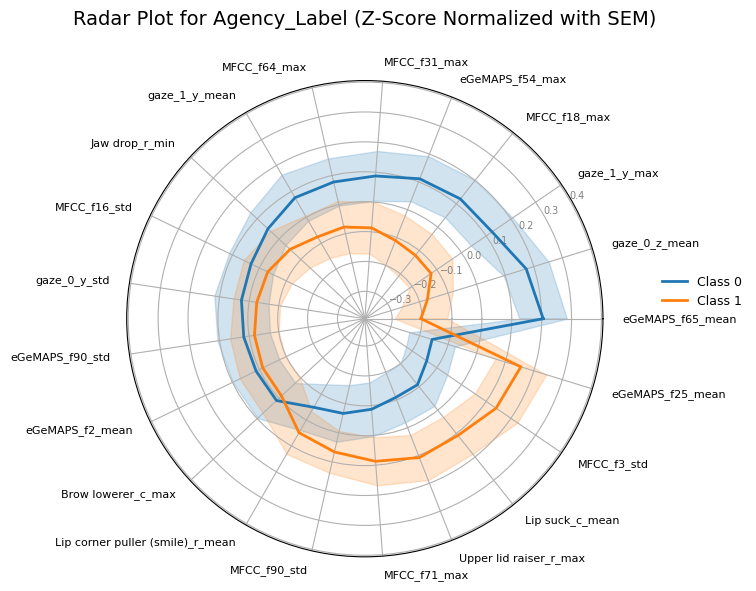

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Agency_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Agency_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and SEM for each class
group_0 = X[df[label_col] == 0][features]
group_1 = X[df[label_col] == 1][features]

mean_0 = group_0.mean()
sem_0 = group_0.sem()

mean_1 = group_1.mean()
sem_1 = group_1.sem()

# Sort features based on difference
diff = mean_1 - mean_0
features_sorted = diff.sort_values().index.tolist()

# Prepare data for plotting
values_0 = mean_0[features_sorted].tolist() + [mean_0[features_sorted].tolist()[0]]
values_1 = mean_1[features_sorted].tolist() + [mean_1[features_sorted].tolist()[0]]

sem_0_vals = sem_0[features_sorted].tolist() + [sem_0[features_sorted].tolist()[0]]
sem_1_vals = sem_1[features_sorted].tolist() + [sem_1[features_sorted].tolist()[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Set center empty
all_vals = np.concatenate([mean_0.values, mean_1.values, mean_0.values - sem_0.values, mean_1.values - sem_1.values])
ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.2)

# Plot mean lines
ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0", color='tab:blue')
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1", color='tab:orange')

# Add standard error shading
ax.fill_between(angles,
                np.array(values_0) - np.array(sem_0_vals),
                np.array(values_0) + np.array(sem_0_vals),
                color='tab:blue', alpha=0.2)

ax.fill_between(angles,
                np.array(values_1) - np.array(sem_1_vals),
                np.array(values_1) + np.array(sem_1_vals),
                color='tab:orange', alpha=0.2)

# Format labels
# Format labels (rotated outward to avoid overlap)
plt.xticks(angles[:-1], pretty_labels, color='black')
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if angle_deg >= 90 and angle_deg <= 270:
        label.set_rotation(angle_deg + 180)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('right')
    else:
        label.set_rotation(angle_deg)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('left')
    label.set_fontsize(8)

ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Title and legend
# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized with SEM)', size=14, y=1.1)

# Move legend outside on the right
plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), fontsize=9, frameon=False)

plt.tight_layout()
plt.show()



['OpenFace_f9_mean', 'OpenFace_f12_std', 'OpenFace_f9_std', 'OpenFace_f11_min', 'OpenFace_f49_mean', 'OpenFace_f8_std', 'OpenFace_f10_min', 'OpenFace_f30_min', 'OpenFace_f48_mean', 'OpenFace_f4_std', 'MFCC_f3_max', 'MFCC_f27_std', 'MFCC_f5_std', 'MFCC_f98_std', 'MFCC_f10_std', 'eGeMAPS_f20_max', 'eGeMAPS_f30_mean', 'eGeMAPS_f16_mean', 'eGeMAPS_f51_std', 'eGeMAPS_f49_max']


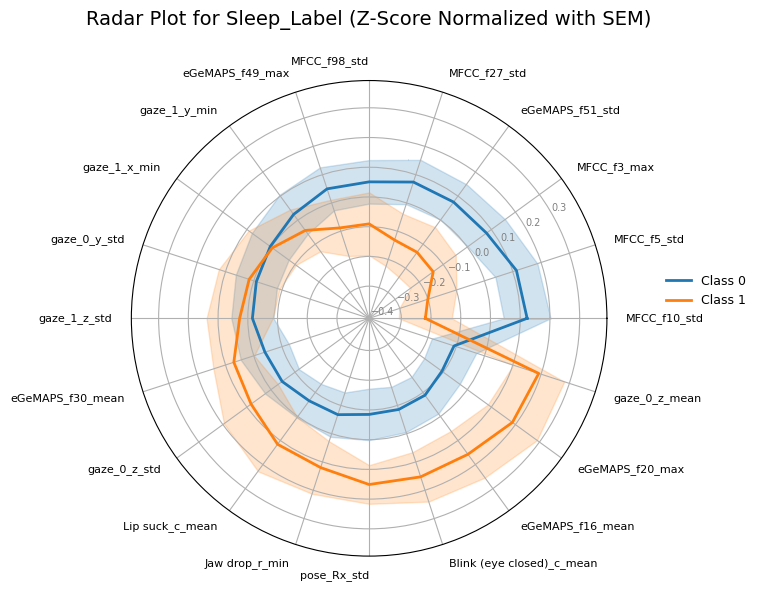

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Sleep_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Sleep_Label'
print(features)
# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and SEM for each class
group_0 = X[df[label_col] == 0][features]
group_1 = X[df[label_col] == 1][features]

mean_0 = group_0.mean()
sem_0 = group_0.sem()

mean_1 = group_1.mean()
sem_1 = group_1.sem()

# Sort features based on difference
diff = mean_1 - mean_0
features_sorted = diff.sort_values().index.tolist()

# Prepare data for plotting
values_0 = mean_0[features_sorted].tolist() + [mean_0[features_sorted].tolist()[0]]
values_1 = mean_1[features_sorted].tolist() + [mean_1[features_sorted].tolist()[0]]

sem_0_vals = sem_0[features_sorted].tolist() + [sem_0[features_sorted].tolist()[0]]
sem_1_vals = sem_1[features_sorted].tolist() + [sem_1[features_sorted].tolist()[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Set center empty
all_vals = np.concatenate([mean_0.values, mean_1.values, mean_0.values - sem_0.values, mean_1.values - sem_1.values])
ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.2)

# Plot mean lines
ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0", color='tab:blue')
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1", color='tab:orange')

# Add standard error shading
ax.fill_between(angles,
                np.array(values_0) - np.array(sem_0_vals),
                np.array(values_0) + np.array(sem_0_vals),
                color='tab:blue', alpha=0.2)

ax.fill_between(angles,
                np.array(values_1) - np.array(sem_1_vals),
                np.array(values_1) + np.array(sem_1_vals),
                color='tab:orange', alpha=0.2)

# Format labels
# Format labels (rotated outward to avoid overlap)
plt.xticks(angles[:-1], pretty_labels, color='black')
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if angle_deg >= 90 and angle_deg <= 270:
        label.set_rotation(angle_deg + 180)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('right')
    else:
        label.set_rotation(angle_deg)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('left')
    label.set_fontsize(8)

ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Title and legend
# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized with SEM)', size=14, y=1.1)

# Move legend outside on the right
plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), fontsize=9, frameon=False)

plt.tight_layout()
plt.show()



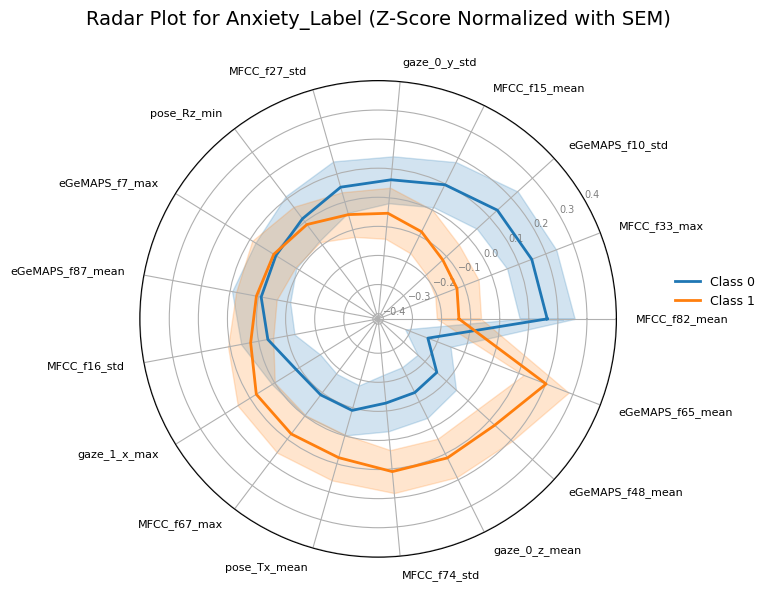

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Anxiety_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Anxiety_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and SEM for each class
group_0 = X[df[label_col] == 0][features]
group_1 = X[df[label_col] == 1][features]

mean_0 = group_0.mean()
sem_0 = group_0.sem()

mean_1 = group_1.mean()
sem_1 = group_1.sem()

# Sort features based on difference
diff = mean_1 - mean_0
features_sorted = diff.sort_values().index.tolist()

# Prepare data for plotting
values_0 = mean_0[features_sorted].tolist() + [mean_0[features_sorted].tolist()[0]]
values_1 = mean_1[features_sorted].tolist() + [mean_1[features_sorted].tolist()[0]]

sem_0_vals = sem_0[features_sorted].tolist() + [sem_0[features_sorted].tolist()[0]]
sem_1_vals = sem_1[features_sorted].tolist() + [sem_1[features_sorted].tolist()[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Set center empty
all_vals = np.concatenate([mean_0.values, mean_1.values, mean_0.values - sem_0.values, mean_1.values - sem_1.values])
ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.2)

# Plot mean lines
ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0", color='tab:blue')
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1", color='tab:orange')

# Add standard error shading
ax.fill_between(angles,
                np.array(values_0) - np.array(sem_0_vals),
                np.array(values_0) + np.array(sem_0_vals),
                color='tab:blue', alpha=0.2)

ax.fill_between(angles,
                np.array(values_1) - np.array(sem_1_vals),
                np.array(values_1) + np.array(sem_1_vals),
                color='tab:orange', alpha=0.2)

# Format labels
# Format labels (rotated outward to avoid overlap)
plt.xticks(angles[:-1], pretty_labels, color='black')
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if angle_deg >= 90 and angle_deg <= 270:
        label.set_rotation(angle_deg + 180)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('right')
    else:
        label.set_rotation(angle_deg)
        label.set_verticalalignment('center')
        label.set_horizontalalignment('left')
    label.set_fontsize(8)

ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Title and legend
# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized with SEM)', size=14, y=1.1)

# Move legend outside on the right
plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), fontsize=9, frameon=False)

plt.tight_layout()
plt.show()



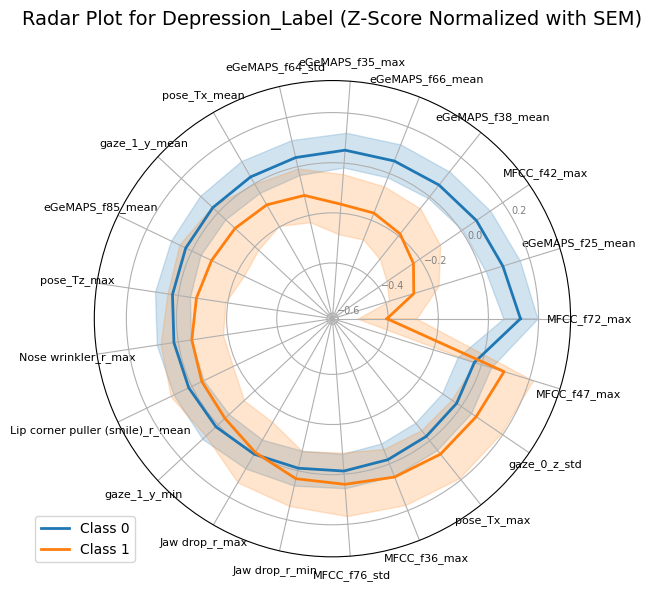

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
features = []
for category, feature in top_shap_feature_by_category["Depression_Label"].items():
    for feat_name, _ in feature:
        features.append(feat_name)
label_col = 'Depression_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean and SEM for each class
group_0 = X[df[label_col] == 0][features]
group_1 = X[df[label_col] == 1][features]

mean_0 = group_0.mean()
sem_0 = group_0.sem()

mean_1 = group_1.mean()
sem_1 = group_1.sem()

# Sort features based on difference
diff = mean_1 - mean_0
features_sorted = diff.sort_values().index.tolist()

# Prepare data for plotting
values_0 = mean_0[features_sorted].tolist() + [mean_0[features_sorted].tolist()[0]]
values_1 = mean_1[features_sorted].tolist() + [mean_1[features_sorted].tolist()[0]]

sem_0_vals = sem_0[features_sorted].tolist() + [sem_0[features_sorted].tolist()[0]]
sem_1_vals = sem_1[features_sorted].tolist() + [sem_1[features_sorted].tolist()[0]]

angles = [n / float(len(features_sorted)) * 2 * pi for n in range(len(features_sorted))] + [0]
pretty_labels = [replace_openface_feature_name(f) for f in features_sorted]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Set center empty
all_vals = np.concatenate([mean_0.values, mean_1.values, mean_0.values - sem_0.values, mean_1.values - sem_1.values])
ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.2)

# Plot mean lines
ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0", color='tab:blue')
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1", color='tab:orange')

# Add standard error shading
ax.fill_between(angles,
                np.array(values_0) - np.array(sem_0_vals),
                np.array(values_0) + np.array(sem_0_vals),
                color='tab:blue', alpha=0.2)

ax.fill_between(angles,
                np.array(values_1) - np.array(sem_1_vals),
                np.array(values_1) + np.array(sem_1_vals),
                color='tab:orange', alpha=0.2)

# Format labels
plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

# Title and legend
plt.title(f'Radar Plot for {label_col} (Z-Score Normalized with SEM)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()


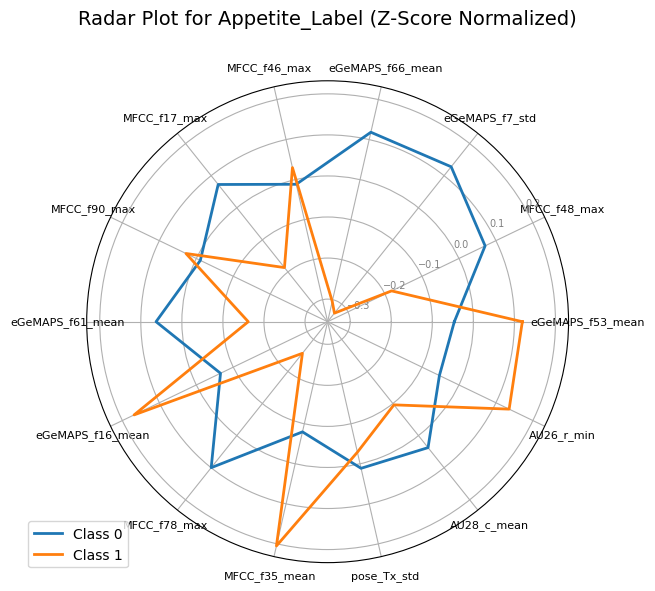

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
top_audio_features =all_audio['Appetite_Label']
top_video_features = all_video['Appetite_Label']
# features = top_feature_df[top_feature_df['Label'] == 'Appetite_Label']['Top Feature']
features = top_audio_features + top_video_features
label_col = 'Appetite_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean for each class
group_0 = X[df[label_col] == 0][features].mean()
group_1 = X[df[label_col] == 1][features].mean()

# Radar plot setup
categories = features
N = len(categories)

# Close the loop
values_0 = group_0.tolist() + [group_0.tolist()[0]]
values_1 = group_1.tolist() + [group_1.tolist()[0]]
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

pretty_labels = [replace_openface_feature_name(f) for f in categories]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0")
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1")

plt.title(f'Radar Plot for {label_col} (Z-Score Normalized)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()


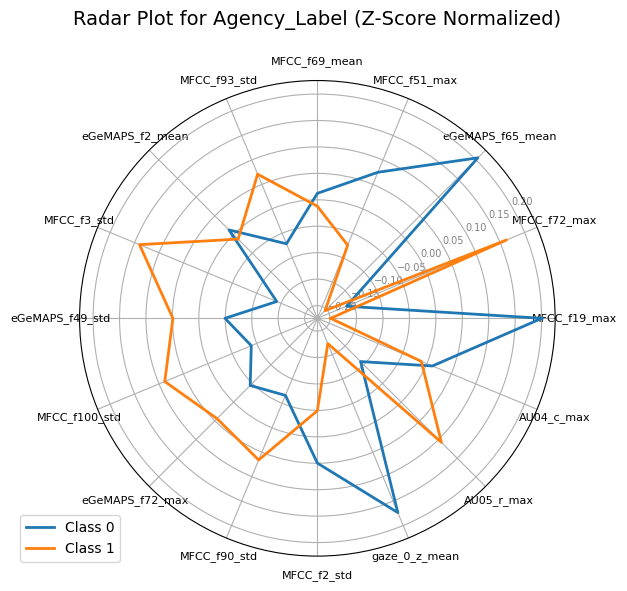

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
top_audio_features =all_audio['Agency_Label']
top_video_features = all_video['Agency_Label']
# features = top_feature_df[top_feature_df['Label'] == 'Agency_Label']['Top Feature']
features = top_audio_features + top_video_features
label_col = 'Agency_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean for each class
group_0 = X[df[label_col] == 0][features].mean()
group_1 = X[df[label_col] == 1][features].mean()

# Radar plot setup
categories = features
N = len(categories)

# Close the loop
values_0 = group_0.tolist() + [group_0.tolist()[0]]
values_1 = group_1.tolist() + [group_1.tolist()[0]]
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

pretty_labels = [replace_openface_feature_name(f) for f in categories]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0")
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1")

plt.title(f'Radar Plot for {label_col} (Z-Score Normalized)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()


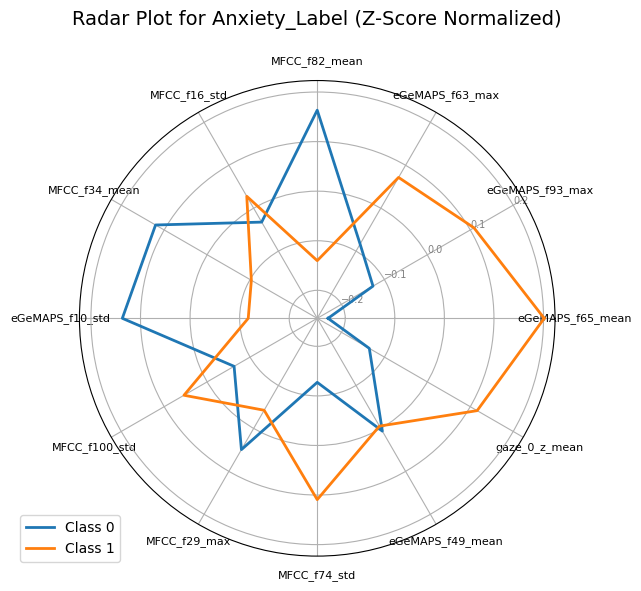

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
top_audio_features =all_audio['Anxiety_Label']
top_video_features = all_video['Anxiety_Label']
# features = top_feature_df[top_feature_df['Label'] == 'Anxiety_Label']['Top Feature']
features = top_audio_features + top_video_features
label_col = 'Anxiety_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean for each class
group_0 = X[df[label_col] == 0][features].mean()
group_1 = X[df[label_col] == 1][features].mean()

# Radar plot setup
categories = features
N = len(categories)

# Close the loop
values_0 = group_0.tolist() + [group_0.tolist()[0]]
values_1 = group_1.tolist() + [group_1.tolist()[0]]
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

pretty_labels = [replace_openface_feature_name(f) for f in categories]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0")
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1")

plt.title(f'Radar Plot for {label_col} (Z-Score Normalized)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()


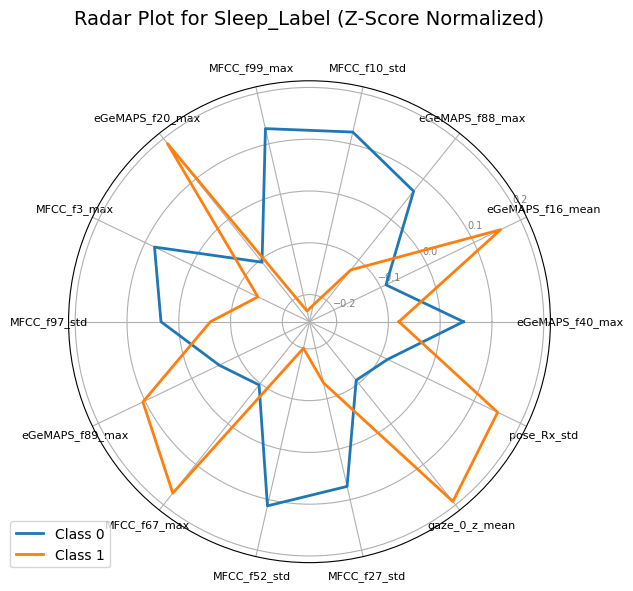

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler

# Define top features
top_audio_features =all_audio['Sleep_Label']
top_video_features = all_video['Sleep_Label']
# features = top_feature_df[top_feature_df['Label'] == 'Sleep_Label']['Top Feature']
features = top_audio_features + top_video_features
label_col = 'Sleep_Label'

# Normalize features using Z-score
X = summary_features.copy()
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Compute mean for each class
group_0 = X[df[label_col] == 0][features].mean()
group_1 = X[df[label_col] == 1][features].mean()

# Radar plot setup
categories = features
N = len(categories)

# Close the loop
values_0 = group_0.tolist() + [group_0.tolist()[0]]
values_1 = group_1.tolist() + [group_1.tolist()[0]]
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

pretty_labels = [replace_openface_feature_name(f) for f in categories]

# Plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], pretty_labels, color='black', size=8)
ax.set_rlabel_position(30)
plt.yticks(color="grey", size=7)

ax.plot(angles, values_0, linewidth=2, linestyle='solid', label="Class 0")
ax.plot(angles, values_1, linewidth=2, linestyle='solid', label="Class 1")

plt.title(f'Radar Plot for {label_col} (Z-Score Normalized)', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load data
df = pd.read_csv('/content/GroundTruth Table.csv')
labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']
model_names = ['Logistic Regression', 'MLP', 'XGBoost', 'SVM', 'Ridge']
THRESHOLD = 0.3  # Can be tuned further

# Dictionary to collect all metrics
results = {model: [] for model in model_names}

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    return round(acc, 4), round(sens, 4), round(spec, 4)

for label in labels:
    print(f"\n=== Processing label: {label} ===")
    X = summary_features.copy()
    y = df[label]

    discrete_features = [False] * X.shape[1]
    mi_scores = make_mi_scores(X, y, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X[filtered_scores.index]

    # Drop highly correlated features
    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    # Select top 20% features
    top_features = final_scores.sort_values(ascending=False).head(int(len(final_scores) * 0.2))
    X = final_X[top_features.index]

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    label_results = {model: {'acc': [], 'sens': [], 'spec': []} for model in model_names}

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Apply SMOTE
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Define models
        classifiers = {
            'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=10000),
            'MLP': MLPClassifier(hidden_layer_sizes=(16,), activation='relu', max_iter=10000),
            'XGBoost': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
            'SVM': SVC(kernel='rbf', probability=True, class_weight='balanced'),
            'Ridge': RidgeClassifier(class_weight='balanced')
        }

        for model_name, model in classifiers.items():
            # Set scale_pos_weight for XGBoost manually
            if model_name == "XGBoost":
                pos = np.sum(y_resampled == 1)
                neg = np.sum(y_resampled == 0)
                model.set_params(scale_pos_weight=neg / pos)

            model.fit(X_resampled, y_resampled)

            # Predict probabilities if available
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                y_pred = (y_prob >= THRESHOLD).astype(int)
            else:
                y_decision = model.decision_function(X_test)
                y_prob = 1 / (1 + np.exp(-y_decision))  # Sigmoid for SVM/Ridge
                y_pred = (y_prob >= THRESHOLD).astype(int)

            acc, sens, spec = compute_metrics(y_test, y_pred)
            label_results[model_name]['acc'].append(acc)
            label_results[model_name]['sens'].append(sens)
            label_results[model_name]['spec'].append(spec)

    # Average across folds
    for model in model_names:
        acc = np.mean(label_results[model]['acc'])
        sens = np.mean(label_results[model]['sens'])
        spec = np.mean(label_results[model]['spec'])
        results[model].extend([acc, sens, spec])

# Build final summary table
columns = [
    f'{label.split("_")[0]}_{metric}'
    for label in labels
    for metric in ['accuracy', 'sensitivity', 'specificity']
]

summary_df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
summary_df.index.name = "Model"

print("\n===== Final Summary Table with SMOTE + Thresholding + Class Weights =====")
print(summary_df)
summary_df.to_csv("classification_summary.csv")



=== Processing label: PTSD_Label ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 